# Elementos de redes neuronales

```{margin}
*Como prerrequisitos para esta lección, sugiero leer la [lección anterior](https://dantenoguez.github.io/Ensayos/elementos-program.html) y el artículo de Khan Academy sobre la [pendiente matemática](https://es.khanacademy.org/math/cc-eighth-grade-math/cc-8th-linear-equations-functions/8th-slope/a/slope-from-two-points).*
```

Este ensayo está inspirado en [micrograd](https://github.com/karpathy/micrograd) de Andrej Karpathy. A continuación, construiremos una red neuronal desde cero, explicando a detalle cada uno de sus elementos.

In [ ]:
!pip install matplotlib --upgrade

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### La derivada

```{margin}
Recomiendo mirar [este video](https://es.khanacademy.org/math/ap-calculus-ab/ab-differentiation-1-new/ab-2-1/v/newton-leibniz-and-usain-bolt) antes de continuar la lectura.
```

En primer lugar es importante entender la derivada, puesto que las redes neuronales la utilizan para «aprender».

Consideremos a la función multiplicación como nuestro primer ejemplo para entenderlas. Conceptualmente, la derivada es muy similar a la pendiente, y mide la **proporción o magnitud del cambio** que una variable provoca en el resultado de una función. Digamos que la derivada mide la fuerza con la que una variable influye en el resultado de una función.

Como ejemplo, midamos el cambio que una variable $a$ (con valores del 0 al 12 en intervalos de 2) provoca en el resultado de una función $c$ (equivalente a multiplicar cada valor de $a$ por 5, o sea, $c = 5x$):

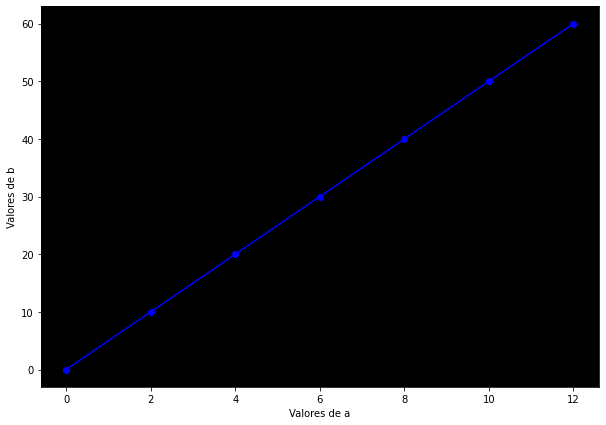

In [2]:
a2 = np.arange(0, 13, 2) 
b2 = 5
def f(a, b): return a*b
c = f(a2, b2)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(a2, c, marker='o', color='blue') 
ax.set_facecolor('black')
ax.set_xlabel('Valores de a')
ax.set_ylabel('Valores de b')
plt.show()

Nuestras correspondencias lucen así:

In [3]:
import pandas as pd
d = {'Valores de a': a2, 'Valores de b': b2, 'Valores de c': c}
tabla = pd.DataFrame(data=d)
tabla = tabla.style.hide_index()
tabla

Valores de a,Valores de b,Valores de c
0,5,0
2,5,10
4,5,20
6,5,30
8,5,40
10,5,50
12,5,60


Lo que la derivada nos señala, como digo, es cuánto influye $a$ en el valor de $c$: si yo sumo 2 a mi primer valor de $a$, es decir, si paso de 0 a 2, ¿cuánto aumenta $c$? $c$ aumenta 5 veces $a$. Si doy otro paso en $a$, es decir, si paso de 2 a 4. ¿cuánto aumenta $c$? Nuevamente, $b$ aumenta 5 veces $a$: $4 \times 5 = 20$. Intuitivamente: dado que $c$ es el resultado de multiplicar 5 veces $a$, es claro que cada valor de $c$ será cinco veces más grande que cada valor correspondiente de $a$.

Así, la derivada de la función $c$ con respecto a $a$ es 5. 5 es la proporción con la que $c$ está cambiando; 5 es la «fuerza» con la que $a$ está influyendo en el resultado de $c$. Es como si no supiéramos que $a$ está siendo multiplicado por $b$ para generar $c$, y entonces aplicáramos nuestro razonamiento matemático para deducirlo. 

Visualicémoslo:

Valores de la derivada en cada punto: [5. 5. 5. 5. 5. 5. 5.]


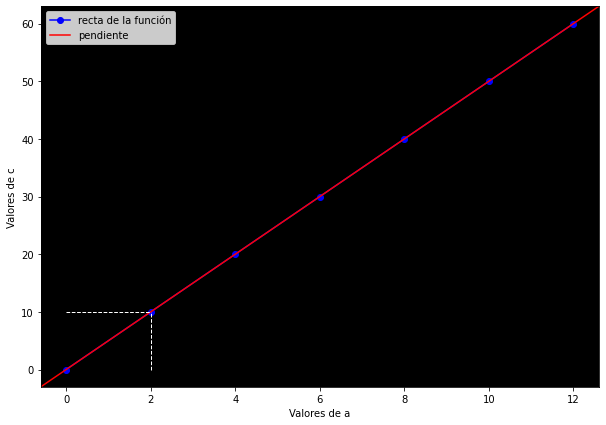

In [4]:
deriv = (f(a2+0.00001, b2) - f(a2, b2)) / 0.00001
print(f'Valores de la derivada en cada punto: {deriv}')

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(a2, c, marker='o', color='blue', label='recta de la función') 
ax.set_facecolor('black')
ax.set_xlabel('Valores de a')
ax.set_ylabel('Valores de c')
ax.axline((a2[1], c[1]), slope=deriv[1], color='red', label='pendiente') # <- La pendiente es la derivada
ax.hlines(y=10, xmin=0, xmax=2, linewidth=1, color='white', linestyles='dashed')
ax.vlines(x=2, ymin=0, ymax=10, linewidth=1, color='white', linestyles='dashed')
ax.legend()
plt.show()

```{margin}
En rigor, la derivada equivale a la pendiente de la línea tangente a un punto de la función. En una función no lineal, por ejemplo, no hablamos de la pendiente de la función, sino de la pendiente de la tangente en un punto (que equivale a la derivada), y la diferencia entre ambas se agudiza cuando agregamos más dimensiones. Aun así, en términos conceptuales, cuando hablamos de dos dimensiones, ambas son equivalentes y la comparación puede ayudar a entender la derivada.
```

La línea tangente al punto derivado (denotado por las líneas punteadas: $a=2, c=10$) resulta tener la misma inclinación que la recta de la función. Geométricamente, en espacios de dos dimensiones, podríamos entender a la derivada como el grado de inclinación de la línea tangente a un punto. Pero dado que todos los segmentos de una recta tienen la misma inclinación, entonces la inclinación de la tangente es la misma que la de la recta y, consecuentemente, la tangente es igual a la pendiente.

En suma, la pendiente y la derivada tienen el mismo valor porque la proporción que guardan los valores de la variable y la función es la misma en todos los puntos: la inclinación de la recta nos la dieron los valores de $a$ y $c$; la proporción entre ellos se ve reflejada en la inclinación; y dicha inclinación representa la «fuerza» con la que $a$ mueve a $c$.

Pongamos otro ejemplo: si los valores de la función nunca cambiaran, entonces la derivada sería 0. Geométricamente, no habría nada de inclinación en la tangente; conceptualmente, la variable no alteraría nunca el resultado de la función, no tendría ninguna influencia en la función, de manera que el «cambio» siempre sería nulo, cero:

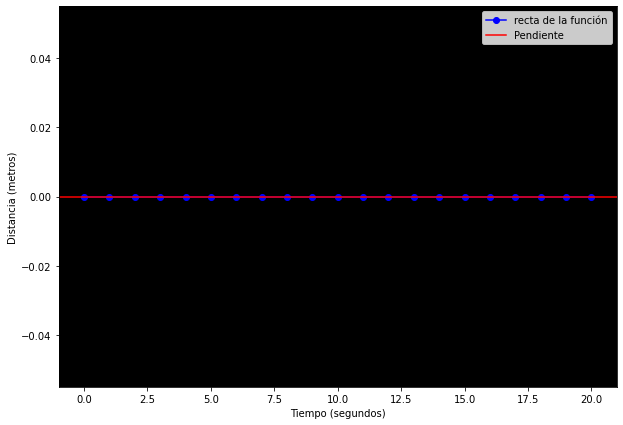

In [5]:
# Supongamos que quiero medir la distancia que recorro en 20 segundos:
# Si con el paso de tiempo no avanzo o, lo que es lo mismo,
# si mi variable tiempo no influye en la función distancia, entonces mi función y mi derivada lucen así:

tiempo = np.arange(0, 21, 1)
def f(t): return t*0
distancia = f(tiempo)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(tiempo, distancia, marker='o', color='blue', label='recta de la función') 
ax.set_facecolor('black')
ax.set_xlabel('Tiempo (segundos)')
ax.set_ylabel('Distancia (metros)')
ax.axline((tiempo[0], distancia[0]), slope=0, color='red', label='Pendiente')
ax.legend()
plt.show()

Veamos otro ejemplo, ahora con la función suma: mi variable $x$ tendrá valores del 0 al 12 con intervalos de 2, mientras que mi función es $x+6$. Mi tabla de valores entonces debería quedar así:

In [6]:
x = np.arange(0, 13, 2)
def f(x): return x+6
y = f(x)

z = {'Valores de x': x, 'Valores de y': y}
tabla = pd.DataFrame(data=z)
tabla = tabla.style.hide_index()
tabla

Valores de x,Valores de y
0,6
2,8
4,10
6,12
8,14
10,16
12,18


Ahora preguntémonos: ¿en qué proporción cambia $y$ cuando aumentamos $x$? Si paso de mi primer valor de $x$ al segundo, es decir, si paso de 0 a 2, ¿cuánto estoy aumentando a mi primer valor de $y$? ¡También dos! Es decir, que la proporción de los cambios entre $x$ e $y$ es 1: si aumento dos a $x$, también aumento 2 a $y$. En nuestro primer ejemplo, si agregábamos 2 a $a$, nuestro valor de $c$ aumentaba cinco veces $a$.

Esto tiene sentido porque la multiplicación aumenta nuestros valores con mayor velocidad y en diferente proporción que la suma: por ejemplo, $2 \times 4 = 8$, pero $2 + 4 = 6$, y conforme tomamos números más grandes, nuestra multiplicación continúa creciendo a mayor velocidad que la suma: $2 \times 10 = 20$, pero $2 + 10 = 12$.

Grafiquemos nuestra nueva función de suma:

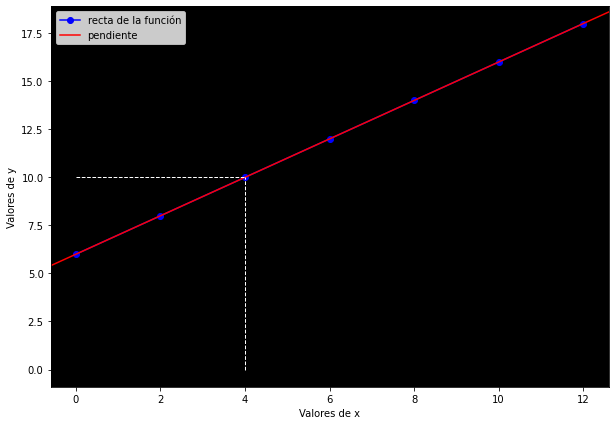

In [7]:
derivada = (y[2] - y[1]) / (x[2] - x[1])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(x, y, marker='o', color='blue', label='recta de la función') 
ax.set_facecolor('black')
ax.set_xlabel('Valores de x')
ax.set_ylabel('Valores de y')
ax.axline((x[1], y[1]), slope=derivada, color='red', label='pendiente')
ax.hlines(y=10, xmin=0, xmax=4, linewidth=1, color='white', linestyles='dashed')
ax.vlines(x=4, ymin=0, ymax=10, linewidth=1, color='white', linestyles='dashed')
ax.legend()
plt.show()

La inclinación de la recta es menor porque $y$ aumenta lentamente en proporción a $x$, de 2 en 2. Una vez más: únicamente estamos averiguando la proporción que hay entre los valores de $x$ y de $y$. Si cada valor de $x$ aumenta significativamente cada valor correspondiente de la función, entonces nuestra derivada será alta y la inclinación de la recta será empinada. 

Por otra parte, cuando cada valor de la función aumenta poco conforme hacemos más grande nuestra variable de entrada, entonces la derivada será pequeña y la inclinación será poca.

Veamos, por último, una función no lineal para distinguir la tangente de la gráfica de la función (esta función no tiene pendiente porque no es una recta):

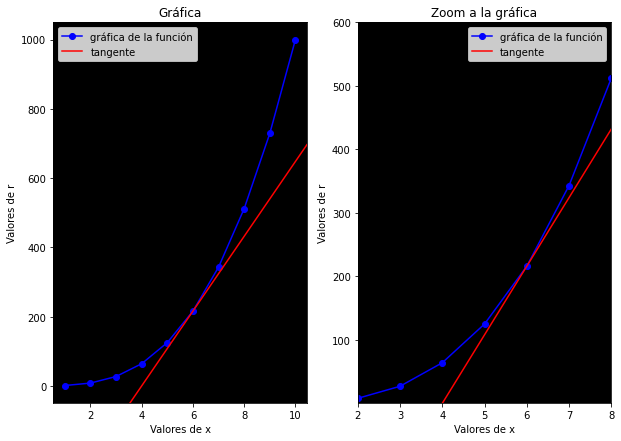

In [8]:
xs = np.arange(1, 11, 1)
ys = [3 for i in xs]
def cub(x, y): return x**y
r = cub(xs, ys)

derivs = (cub(xs+0.00001, ys) - cub(xs, ys)) / 0.00001

fig, ax = plt.subplots(ncols=2, figsize=(10, 7))
ax[0].plot(xs, r, marker='o', color='blue', label='gráfica de la función')
ax[0].set_title('Gráfica')
ax[0].set_facecolor('black')
ax[0].set_xlabel('Valores de x')
ax[0].set_ylabel('Valores de r')
ax[0].axline((xs[5], r[5]), slope=derivs[5], color='red', label='tangente')
ax[0].legend()
ax[1].plot(xs, r, marker='o', color='blue', label='gráfica de la función') 
ax[1].set_title('Zoom a la gráfica')
ax[1].set_facecolor('black')
ax[1].set_xlabel('Valores de x')
ax[1].set_ylabel('Valores de r')
ax[1].axline((xs[5], r[5]), slope=derivs[5], color='red', label='tangente')
ax[1].set_xlim(xs[1], xs[7])
ax[1].set_ylim(r[0], 600)
ax[1].legend()
plt.show()

En este último caso, la proporción entre $x$ y el resultado de la función nos la da la fórmula $yx^{y-1}$. Por ejemplo, la derivada del punto a partir del cual trazamos la tangente anterior se puede calcular así:

$$
yx^{y-1}
$$

$$
y = 3, x = 6, y-1=2
$$

$$
3(6^2) = 3(36) = 108
$$

¿De dónde sale esa fórmula? Bueno, estas fórmulas las averiguan matemáticos que estudian los patrones lógico-abstractos de las expresiones matemáticas. Es lo mismo que hacíamos en nuestro primer ejemplo al calcular que 2 multiplicaba a 5; en este caso, aunque más complejo, es prácticamente lo mismo.

Ahora que ya entendemos conceptualmente la derivada, estudiemos brevemente sus fórmulas matemáticas. Una manera de definir la derivada es:

$
f^{\prime}(x)=\lim _{h \rightarrow 0} \frac{f(x+h)-f(x)}{h}
$

Otra fórmula luce así:
$
\frac{\partial f(x, y)}{\partial x}=\frac{f(x+h, y)-f(x, y)}{h}
$

```{margin}
Sobre límites se puede leer [este artículo](https://es.khanacademy.org/math/ap-calculus-ab/ab-limits-new/ab-1-2/a/limits-intro?modal=1); sobre derivadas, [estos videos](https://es.khanacademy.org/math/ap-calculus-ab/ab-differentiation-1-new).
```

Por una parte, es importante familiarizarnos con la notación matemática, así podremos identificar estos conceptos y fórmulas en los textos académicos. Los signos $\delta, \Delta$ son letras del alfabeto griego llamadas «delta» (la primera es minúscula; la segunda, mayúscula), y generalmente se utilizan para representar un cambio. El símbolo $\lim _{h \rightarrow 0}$ significa «el límite de la función cuando $h$ tiende a 0»

Ambas fórmulas significan lo mismo. Si prestamos atención, ambas realizan una resta para medir el impacto de la variable en la función, y después una división para estimar la proporción de dicho cambio. En Wikipedia, se define a la derivada de una función como una «razón de cambio instantánea con la que varía el valor de dicha función matemática, según se modifique el valor de su variable independiente». En otras palabras, es lo que decíamos: la derivada mide la proporción (o razón, o tasa, o magnitud) del cambio que los valores de la variable provocan en la función en un punto determinado.

### Pero ¿para qué sirve la derivada?

Imaginemos que tenemos dos variables: $x = -2$ y $y = 3$. El resultado de multiplicarlas es $-6$, pero queremos alterar ese resultado para llegar a $0$ y tenemos una restricción: la única manera de hacerlo es a través de las entradas. Para ello, podríamos pensar en aumentar o disminuir las entradas en pasos pequeños y probar aleatoriamente hasta conseguir el resultado.

```{margin}
Ojo: disminuir el 3 aumenta el resultado, puesto que está siendo multiplicado por un número negativo. Ejemplo: 3-1 = 2, 2*-2 = -4, y -4 es menor que -6, el resultado inicial.
```
Supongamos que nuestro cambio aplicado será $0.01$: disminuiremos $y$ en esa cantidad y aumentaremos $x$ de la misma forma: $x = -1.99 \times y = 2.99 = -5.95$. Bien, $-5.95$ es más cercano a $0$ que $-6$; sin embargo, este método no parece muy efectivo, especialmente considerando que las redes neuronales contendrán miles de millones de estas operaciones.

Si recordamos la lección aprendida en las derivadas, se nos puede ocurrir utilizarlas para resolver este problema: dado que la derivada me dice el impacto que tiene una variable de entrada en la función, ¿será posible utilizarla para alterar el resultado? Es decir, si la derivada me dice cuándo una varible tiene un impacto negativo, positivo, alto o pequeño, entonces debería poder utilizar información para influir en el resultado de manera más eficiente. Si la derivada me indica que una variable influye positivamente en el resultado, pero yo quiero disminuirlo, entonces sabré que debo disminuir esa variable, y así sucesivamente.

### Pequegrad

Para entender mejor la posible solución planteada, crearemos primero la clase `Numero`, es decir, formularemos una estructura que nos permita definir, modificar y operar con números. Dado que las redes neuronales son gigantescas expresiones matemáticas, los números serán nuestros elementos primarios. De momento, cada `Numero` tendrá las siguientes propiedades: un `valor`, un par de valores `previos` para el caso de que el `valor` haya sido generado mediante una operación (por ejemplo, 2 y 2 en el caso de que multiplicados hayan generado el número 4), la `operación` que generó dicho valor (en nuestro ejemplo, la multiplicación) y una etiqueta en caso de que queramos asociar nuestro `valor` a una variable. Por ahora, únicamente tendremos las operaciones de suma, multiplcación, resta y división:

In [9]:
class Numero:
  def __init__(self, valor, _previos=(), _op='', etiqueta=''):
    self.valor = valor
    self._previos = set(_previos)
    self._op = _op
    self.etiqueta = etiqueta

  def __add__(self, otro): # adición
    otro = otro if isinstance(otro, Numero) else Numero(otro) # nos cercioramos de que el otro valor sea un Número
    resultado = Numero(self.valor + otro.valor, (self, otro), '+')
    return resultado

  def __radd__(self, otro): 
    return self + otro

  def __mul__(self, otro): # multiplicación
    otro = otro if isinstance(otro, Numero) else Numero(otro)
    resultado = Numero(self.valor * otro.valor, (self, otro), '*')
    return resultado

  def __rmul__(self, otro):
    return self * otro

  def __sub__(self, otro): # resta, substracción
    return self + (-otro)

  def __truediv__(self, otro): # división
    return self * otro**-1 #dividir es lo mismo que multiplicar por el dividendo elevado a la menos 1
  
  def __rtruediv__(self, otro):
    return otro * self**-1

  def __neg__(self): # volver negativo un número
    return self * -1

  def __repr__(self):
    return f'Valor={self.valor}' # esta función determina cómo se representa nuestro número

Utilizaremos un problema más desafiante que una simple multiplicación:

In [10]:
# Utilizaremos nuestra clase para crear la función L con los siguientes números y operaciones:

a = Numero(-2.0, etiqueta='a')
b = Numero(3.0, etiqueta='b')
c = a*b; c.etiqueta = 'c' # definimos c, que es el resultado de multiplicar a y b
d = Numero(10.0, etiqueta='d')
e = c + d; e.etiqueta = 'e'
f = Numero(-3.0); f.etiqueta = 'f'
L = f * e; L.etiqueta= 'L'

print(f'Ejemplo: Valor de c: {c} | Valores previos: {c._previos} | Operación realizada para generar c: {c._op}')

Ejemplo: Valor de c: Valor=-6.0 | Valores previos: {Valor=-2.0, Valor=3.0} | Operación realizada para generar c: *


```{margin}
El código para graficar no tiene que ver con las redes neuronales, de manera que queda fuera de nuestro enfoque explicarlo.
```

También crearemos una función para graficar nuestras operaciones:

In [11]:
from graphviz import Digraph

def rastreo(origen):
  # construye un conjunto de todos los nodos en un gráfico
  nodos, lineas = set(), set()
  def construir(v):
    if v not in nodos:
      nodos.add(v)
      for parte in v._previos:
        lineas.add((parte, v))
        construir(parte)
  construir(origen)
  return nodos, lineas

def graficar(origen):
  grafica = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right, izquierda a derecha

  nodos, lineas = rastreo(origen)
  for n in nodos:
    uid = str(id(n))
    # por cada valor en la gráfica, crea un nodo rectangular ('record') para él
    grafica.node(name=uid, label='{ %s | valor %.4f}' % (n.etiqueta, n.valor), shape='record')
    if n._op:
      # si el valor es resultado de una operación, crea un nodo para la operación
      grafica.node(name = uid + n._op, label = n._op)
      # conecta los nodos
      grafica.edge(uid + n._op, uid)

  for n1, n2 in lineas:
    # conecta n1 al nodo operación de n2
    grafica.edge(str(id(n1)), str(id(n2)) + n2._op)

  return grafica

Finalmente, visualizamos la función. El problema a resolver consiste en influir en los valores de la función $L$ para llevarla a 0.

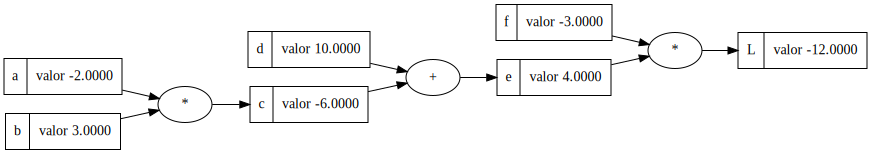

In [12]:
graficar(L)

Como decíamos, intuitivamente creemos que la derivada puede ayudarnos: con la derivada sabemos qué impacto tiene cada variable en el resultado final $L$. En ese sentido, lo que tendremos que hacer primero es calcular la derivada de cada variable con respecto a $L$.

En principio, la derivada de $L$ con respecto a sí misma es 1: aunque suene absurdo y evidente a la vez, el cambio en $L$ es proporcional (idéntico) a sí mismo. Ahora, la derivada de $f$ y $e$ con respecto a $L$ la podemos averiguar con la fórmula que veníamos utilizando:

In [13]:
def derivada():
  h = 0.000001

  # Función original
  a = Numero(-2.0, etiqueta='a')
  b = Numero(3.0, etiqueta='b')
  c = a*b; c.etiqueta = 'c'
  d = Numero(10.0, etiqueta='d')
  e = c + d; e.etiqueta = 'e'
  f = Numero(-3.0); f.etiqueta = 'f'
  L1 = f * e; L.etiqueta= 'L1'

  # Función con incremento h
  a = Numero(-2.0, etiqueta='a')
  b = Numero(3.0, etiqueta='b')
  c = a*b; c.etiqueta = 'c'
  d = Numero(10.0, etiqueta='d')
  e = c + d; e.etiqueta = 'e'
  e.valor += h # aumento de h para obtener la derivada de e con respecto a L
  f = Numero(-3.0); f.etiqueta = 'f'
  L2 = f * e; L.etiqueta= 'L2'

  print((L2 - L1) / h) # fórmula de la derivada

derivada()

Valor=-2.9999999995311555


La derivada de $e$ con respecto a la función es aproximadamente -3. A estas alturas, ya habremos notado un patrón: cuando derivamos una multiplicación, el resultado es la otra variable multiplicadora. En este caso, $L$ es el resultado de multiplicar $e$ con $f$. Vimos que la derivada de $e$ es -3, o sea $f$. Podemos inducir, empíricamente y por simetría, que la derivada de $f$ es $e$, o sea 4.

Ahora que ya tenemos esta información, queremos continuar al nodo anterior: las derivadas de $c$ y $d$. Pero aquí hay una sutileza que, bien entendida, nos dará la clave de las redes neuronales: debemos obtener la derivada de $c$ y $d$ con respecto a $L$, no con respecto a $e$. Entonces, ¿cómo podemos averiguar el impacto que $c$ y $d$ tienen en $L$ a través de $e$? Para hacer este cálculo solo hace falta una intuición bastante simple.

### La regla de la cadena: propagación hacia atrás
Tomemos prestada la analogía de George Simmons: si una bicicleta es dos veces más rápida que una persona corriendo, y un automóvil cuatro veces más rápido que una bicicleta, entonces el automóvil es $2 \times 4 = 8$ veces más rápido que una persona corriendo.

De igual forma, si queremos saber la influencia que $c$ tiene en $L$, solo debemos obtener la derivada de $c$ con respecto a $e$, y multiplicarla por la derivada de $e$ con respecto a $L$. Es decir, debemos multiplicar la fuerza de $c$ y la de $e$ para saber con cuánta fuerza influye $c$ en $L$. Lo mismo vale para $d$ y todas las demás; a esta regla se le llama «regla de la cadena» (o «propagación hacia atrás» en el campo de la inteligencia artificial).

Ahora, para obtener la derivada de $c$ con respecto a $e$, recordemos otro patrón que vimos: en una suma, la derivada nos daba como resultado 1 porque la función avanzaba en la misma proporción que avanzaba la variable. Verifiquémoslo:

In [14]:
def deriv_c(c, d):
  return (((c+0.00001)+d) - (c+d)) / 0.00001

deriv_c(-6, 10)

0.9999999999621422

En efecto, el resultado es aproximadamente 1. Por simetría nuevamente, entendemos que la derivada de $d$ con respecto a $e$ también es 1. Y ahora que ya tenemos ambas derivadas podemos multiplicarlas: $1 \times -3 = -3$. Así pues, la derivada de $d$ y $c$ con respecto a $L$ es -3. Comprobémoslo:

In [15]:
def derivada():
  h = 0.000001

  # Función original
  a = Numero(-2.0, etiqueta='a')
  b = Numero(3.0, etiqueta='b')
  c = a*b; c.etiqueta = 'c'
  d = Numero(10.0, etiqueta='d')
  e = c + d; e.etiqueta = 'e'
  f = Numero(-3.0); f.etiqueta = 'f'
  L1 = f * e; L.etiqueta= 'L1'

  # Función con incremento h
  a = Numero(-2.0, etiqueta='a')
  b = Numero(3.0, etiqueta='b')
  c = a*b; c.etiqueta = 'c'
  c.valor += h # aumento de h para obtener la derivada de c con respecto a L
  d = Numero(10.0, etiqueta='d')
  e = c + d; e.etiqueta = 'e'
  f = Numero(-3.0); f.etiqueta = 'f'
  L2 = f * e; L.etiqueta= 'L2'

  print((L2 - L1) / h) # fórmula de la derivada

derivada()

Valor=-2.9999999995311555


Finalmente, debemos hacer lo mismo para obtener las derivadas de $a$ y $b$. Entonces, dado el patrón que habíamos descubierto, la derivada de $a$ con respecto a $c$ es $b$, o sea $3$, y viceversa: la derivada de $b$ es $a$, o sea $-2$. Pero recordemos: esta derivada «local» está dada con respecto a $c$, y a nosotros nos interesa la derivada con respecto a $L$, es decir, la magnitud de la influencia que $a$ y $b$ tienen en $L$. Para saberlo, únicamente debemos aplicar la regla de la cadena y multiplicar las derivadas que tenemos por la derivada de $c$. Entonces la derivada de $a$ es $3 \times -3 = -9$, mientras que la derivada de $b$ es $-2 \times -3 = 6$.
```{margin}
A la derivada global, es decir, a la que se da con respecto al resultado final y no al local, se le denomina «gradiente». Las fórmulas que utilizamos para derivar pueden leerse [aquí](https://es.wikipedia.org/wiki/Derivada#Cálculo_de_la_derivada); algunas fórmulas que utilizaremos a continuación, [aquí](https://aew61.github.io/blog/artificial_neural_networks/1_background/1.b_activation_functions_and_derivatives.html).
```

Ahora que ya tenemos estos valores, podemos optimizar nuestro código para contemplarlos y visualizarlos de mejor manera. Añadiremos también algunas funciones que después detallaremos. En la práctica, nadie calcula las derivadas manualmente como lo hicimos, puesto que sería una labor eterna; pero ya hemos aprendido los patrones para calcularlas, así que podemos implementarlos en nuestro código para que se calculen automáticamente:

In [1]:
import math

class Numero:
  def __init__(self, valor, _previos=(), _op='', etiqueta=''):
    self.valor = valor
    self.grad = 0.0 # gradiente, comienza en 0
    self._propagar = lambda: None # el valor predeterminado de la propagación hacia atrás es nulo
    self._previos = set(_previos)
    self._op = _op
    self.etiqueta = etiqueta

  def __add__(self, otro): 
    otro = otro if isinstance(otro, Numero) else Numero(otro) 
    resultado = Numero(self.valor + otro.valor, (self, otro), '+')

    def _propagar():
      self.grad += 1.0 * resultado.grad # la derivada de una suma es 1 y luego se multiplica por la «derivada global»
      otro.grad += 1.0 * resultado.grad
    resultado._propagar = _propagar

    return resultado

  def __radd__(self, otro): 
    return self + otro

  def __mul__(self, otro):
    otro = otro if isinstance(otro, Numero) else Numero(otro)
    resultado = Numero(self.valor * otro.valor, (self, otro), '*')

    def _propagar():
      self.grad += otro.valor * resultado.grad # la derivada de la multiplicación es igual al multiplicando por la derivada global
      otro.grad += self.valor * resultado.grad
    resultado._propagar = _propagar

    return resultado

  def __rmul__(self, otro):
    return self * otro

  def __pow__(self, otro): # potenciación
    assert isinstance(otro, (int, float))
    resultado = Numero(self.valor**otro, (self,), f'**{otro}')

    def _propagar():
      self.grad += otro * (self.valor ** (otro - 1)) * resultado.grad # recordemos la fórmula: yx**y-1
    resultado._propagar = _propagar

    return resultado

  def __sub__(self, otro): 
    return self + (-otro)

  def __rsub__(self, otro):
    return otro + (-self)

  def __neg__(self): 
    return self * -1

  def __truediv__(self, otro): 
    return self * otro**-1 
  
  def __rtruediv__(self, otro):
    return otro * self**-1

  def ReLU(self): 
    resultado = Numero((0 if self.valor < 0 else self.valor), (self,), 'ReLU')

    def _propagar():
      self.grad += (1 if resultado.valor > 0 else 0) * resultado.grad # la derivada es 1 si x > 0, 0 si x < 0
    resultado._propagar = _propagar
    
    return resultado

  def tanh(self): # tangente hiperbólica
    t = (math.exp(2*self.valor) - 1) / (math.exp(2*self.valor) + 1)
    resultado = Numero(t, (self,), 'tanh')

    def _propagar():
      self.grad += (1 - t**2) * resultado.grad # según la fórmula 1-tanh**2x
    resultado._propagar = _propagar

    return resultado

  def sigmoide(self):
    s = 1/(1 + math.exp(self.valor))
    resultado = Numero(s, (self,), 'sigmoide')

    def _propagar():
      self.grad += (s * (1 - s)) * resultado.grad # la derviada es s(x)(1-s(x))
    resultado._propagar = _propagar

    return resultado

  def exp(self): # exponenciación
    resultado = Numero(math.exp(self.valor), (self,), 'exp')

    def _propagar():
      self.grad += self.valor * resultado.grad
    resultado._propagar = _propagar

    return resultado

  def log(self): # logaritmo natural
    resultado = Numero(math.log(self.valor), (self,), 'log')

    def _propagar():
      self.grad += 1/self.valor * resultado.grad
    resultado._propagar = _propagar

    return resultado

  def propagar(self):
    # ordenamiento topológico
    topo = []
    visitados = set()
    def construir_topo(v):
      if v not in visitados:
        visitados.add(v)
        for previo in v._previos:
          construir_topo(previo)
        topo.append(v)
    construir_topo(self)

    self.grad = 1 # asignamos la derivada del valor final con respecto a sí mismo: 1
    for nodo in reversed(topo): # comenzamos desde adelante hacia atrás
      nodo._propagar()

  def __repr__(self):
    return f'Valor={self.valor}'

In [2]:
from graphviz import Digraph

def rastreo(origen):
  nodos, lineas = set(), set()
  def construir(v):
    if v not in nodos:
      nodos.add(v)
      for parte in v._previos:
        lineas.add((parte, v))
        construir(parte)
  construir(origen)
  return nodos, lineas

def graficar(origen):
  grafica = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodos, lineas = rastreo(origen)
  for n in nodos:
    uid = str(id(n))
    grafica.node(name=uid, label='{ %s | valor %.4f | grad %.4f}' % (n.etiqueta, n.valor, n.grad), shape='record')
    if n._op:
      grafica.node(name = uid + n._op, label = n._op)
      grafica.edge(uid + n._op, uid)

  for n1, n2 in lineas:
    grafica.edge(str(id(n1)), str(id(n2)) + n2._op)

  return grafica

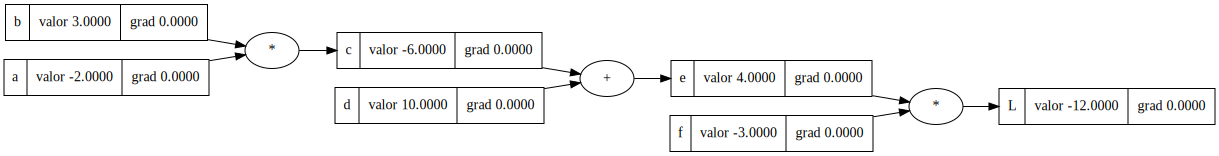

In [3]:
a = Numero(-2.0, etiqueta='a')
b = Numero(3.0, etiqueta='b')
c = a*b; c.etiqueta = 'c'
d = Numero(10.0, etiqueta='d')
e = c + d; e.etiqueta = 'e'
f = Numero(-3.0); f.etiqueta = 'f'
L = f * e; L.etiqueta= 'L'

graficar(L)

Ahora obtendremos las derivadas, pero programática en vez de manualmente:

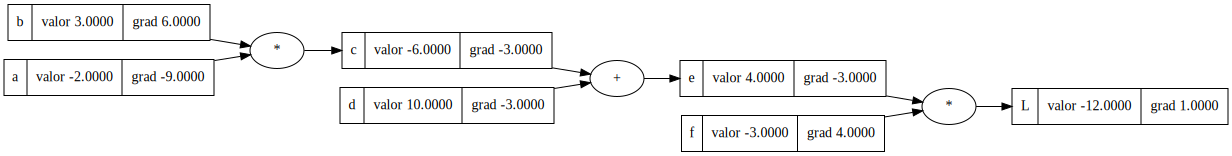

In [4]:
L.propagar()
graficar(L)

Bien. Ahora pongamos en práctica nuestra intuición: dado que el gradiente (o derivada global) nos dice la «fuerza» con la que cada número influye en el valor final, podemos utilizar esa misma fuerza para aumentar proporcionalmente nuestros valores y, con ello, aumentar el valor de $L$. La bondad de utilizar el gradiente es que nos indica la «dirección» en la que debemos modificar cada valor para aumentar el resultado final.

Solo hace falta un detalle: al emplear esta estrategia, debemos ser cuidadosos de no excedernos en el aumento del resultado, puesto que queremos llegar a 0 sin superarlo. Para ello, podemos atenuar la fuerza de las derivadas, multiplicándolas por un número pequeño como 0.01 o 0.1. Probemos un ejemplo con la variable $a$:

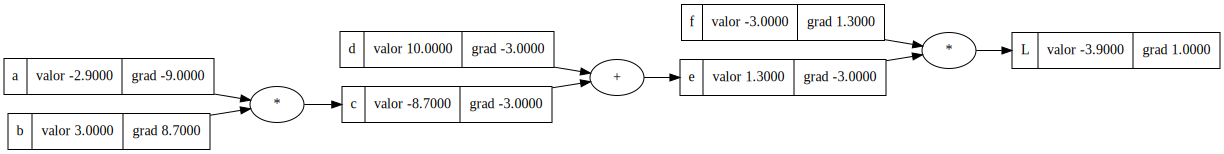

In [5]:
na = a + 0.1 * a.grad # nuevo valor de a: su derivada multiplicada por 0.1

a = Numero(na.valor, etiqueta='a') # asignamos el nuevo valor a la variable
b = Numero(3.0, etiqueta='b')
c = a*b; c.etiqueta = 'c'
d = Numero(10.0, etiqueta='d')
e = c + d; e.etiqueta = 'e'
f = Numero(-3.0); f.etiqueta = 'f'
L = f * e; L.etiqueta= 'L'

L.propagar()

graficar(L)

Bien, parece que nuestro método funciona. Sin embargo, comprobamos que quizá nuestra fuerza es elevada, puesto que disminuyó mucho el resultado. Probablemente tengamos un mejor resultado si hacemos esto con todas nuestras variables, pero con una fuerza más atenuada (0.01):

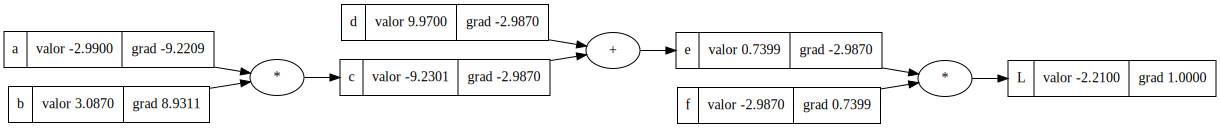

In [6]:
na = a + 0.01 * a.grad
nb = b + 0.01 * b.grad
nd = d + 0.01 * d.grad
nf = f + 0.01 * f.grad

a = Numero(na.valor, etiqueta='a')
b = Numero(nb.valor, etiqueta='b')
c = a*b; c.etiqueta = 'c'
d = Numero(nd.valor, etiqueta='d')
e = c + d; e.etiqueta = 'e'
f = Numero(nf.valor); f.etiqueta = 'f'
L = f * e; L.etiqueta= 'L'

L.propagar()

graficar(L)

Aunque no hayamos conseguido un resultado de exactamente 0, nos hemos aproximado significativamente con nuestro nuevo método programático. Pronto explotaremos el verdadero poder detrás de esta nueva herramienta nuestra, aunque desde ya podamos proclamar —con Françoise Hardy— ¡voilà! Esta es la esencia del aprendizaje en una red neuronal.

<iframe style="border-radius:12px" src="https://open.spotify.com/embed/track/4YIZP4nlw3jV5DkXGB56iG?utm_source=generator" width="100%" height="152" frameBorder="0" allowfullscreen="" allow="autoplay; clipboard-write; encrypted-media; fullscreen; picture-in-picture" loading="lazy"></iframe>

---

### Perceptrón multicapa

En nuestro último ejercicio construimos una neurona; sin embargo, el poder de una red neuronal consiste en que tiene millones de neuronas, todas optimizando sus valores para darnos el resultado que deseamos. Antes de poner en práctica nuestro aprendizaje, programaremos una red neuronal llamada «perceptrón multicapa» (o MLP, *Multilayer Perceptron*):

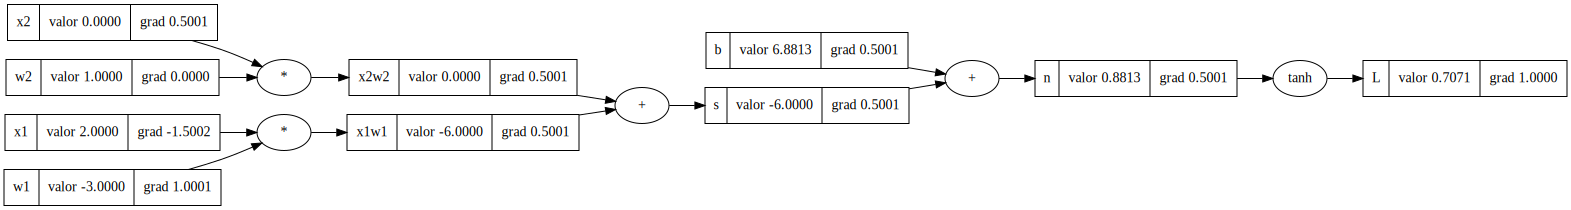

In [7]:
#entradas
x1 = Numero(2.0, etiqueta='x1')
x2 = Numero(0.0, etiqueta='x2')

# pesos (weights)
w1 = Numero(-3.0, etiqueta='w1')
w2 = Numero(1.0, etiqueta='w2')

# sesgo (bias)
b = Numero(6.8813, etiqueta='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.etiqueta='x1w1'
x2w2 = x2*w2; x2w2.etiqueta='x2w2'
sumatoria = x1w1 + x2w2; sumatoria.etiqueta='s'
n = sumatoria + b; n.etiqueta='n'

# activación
L = n.tanh(); L.etiqueta= 'L'

L.propagar()

graficar(L)

In [8]:
import random

class Neurona:
  def __init__(self, nentradas):
    self.peso = [Numero(random.uniform(-1,1)) for i in range(nentradas)] # cada entrada tendrá un peso, que será un número aleatorio
    self.sesgo = Numero(random.uniform(-1,1)) # un sesgo con valor aleatorio del -1 al 1

  def __call__(self, x):
    # peso * x + sesgo
    activacion = sum((peso_i*x_i for peso_i, x_i in zip(self.peso, x)), self.sesgo)
    resultado = activacion.tanh()
    return resultado

  def parametros(self):
    return self.peso + [self.sesgo]

class Capa: #Layer
  def __init__(self, nentradas, nsalidas):
    self.neuronas = [Neurona(nentradas) for _ in range(nsalidas)]

  def __call__(self, x):
    resultado = [n(x) for n in self.neuronas]
    return resultado[0] if len(resultado) == 1 else resultado

  def parametros(self):
    return [parametro for n in self.neuronas for parametro in n.parametros()]

class MLP:
  def __init__(self, nentrada, nsalidas):
    tamaño = [nentrada] + nsalidas
    self.capas = [Capa(tamaño[i], tamaño[i+1]) for i in range(len(nsalidas))]

  def __call__(self, x):
    for capa in self.capas:
      x = capa(x)
    return x

  def parametros(self):
    return [parametro for capa in self.capas for parametro in capa.parametros()]

In [9]:
x = [3.0]
N = Neurona(1)
N(x)

Valor=0.9586034461059985

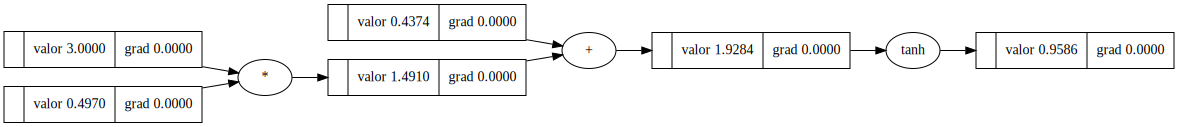

In [10]:
graficar(N(x))

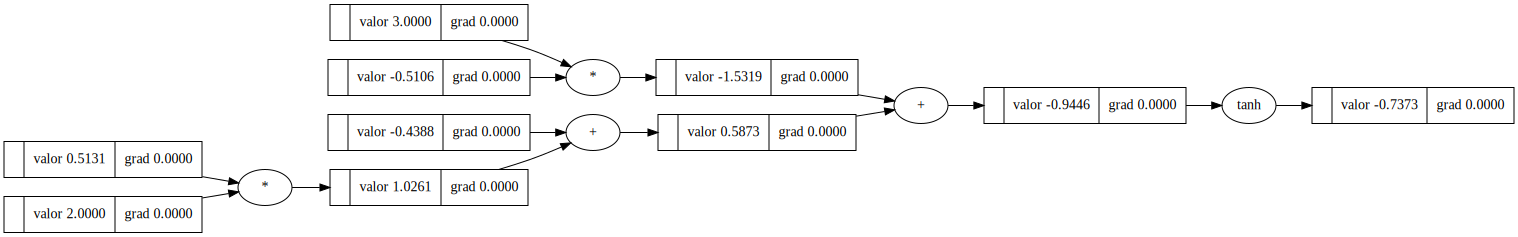

In [11]:
x = [2.0, 3.0]
C = Capa(2, 1)
graficar(C(x))

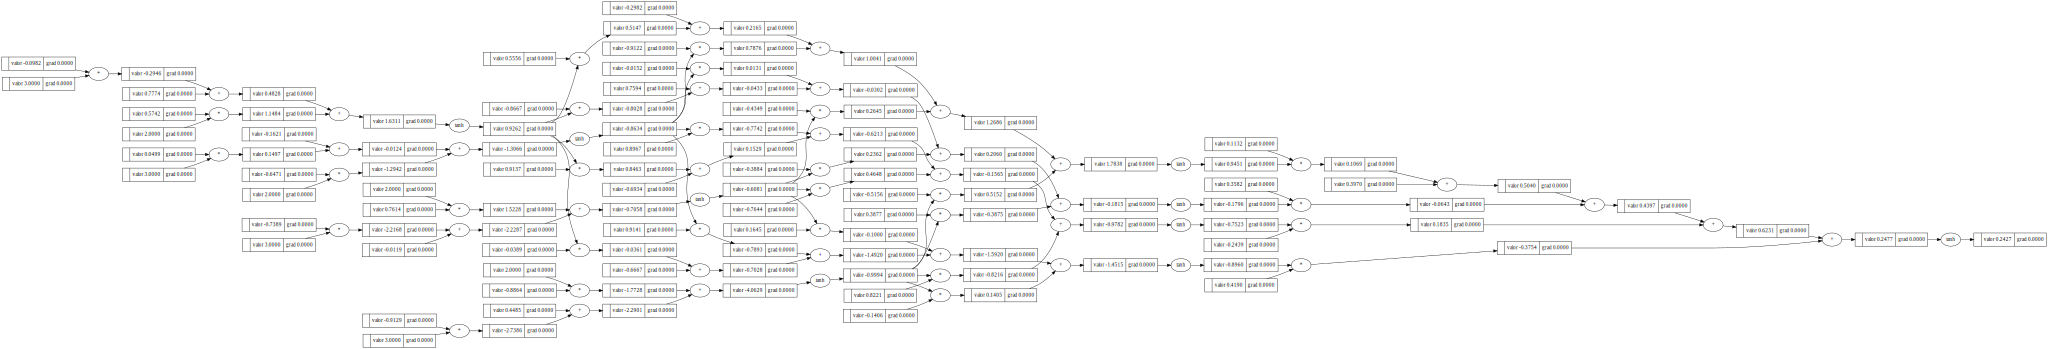

In [31]:
x = [3.0, 2.0]
RN = MLP(3, [4, 4, 1])

graficar(RN(x))

In [54]:
entradas = [
    [1.0, 2.0, 3.0],
    [3.0, 2.0, 1.0],
    [0.5, 1.0, -1.0],
    [1.0, 1.0, -1.0],
]

objetivos = [1.0, -1.0, -1.0, 1.0]
predicciones = [RN(x) for x in entradas]
predicciones

[Valor=0.9760640284876828,
 Valor=0.9760988173157867,
 Valor=-0.6553534221135854,
 Valor=0.6332366822158839]

In [55]:
fn_perdida = [(pred - obj)**2 for pred, obj in zip(predicciones, objetivos)] #MSE
fn_perdida

[Valor=0.00057293073223846,
 Valor=3.9049665357968513,
 Valor=0.11878126364881646,
 Valor=0.1345153312720125]

In [56]:
perdida = sum(fn_perdida)
perdida

Valor=4.158836061449919

In [57]:
perdida.propagar()

In [58]:
RN.capas[0].neuronas[0].peso[0].grad

0.02320253291320547

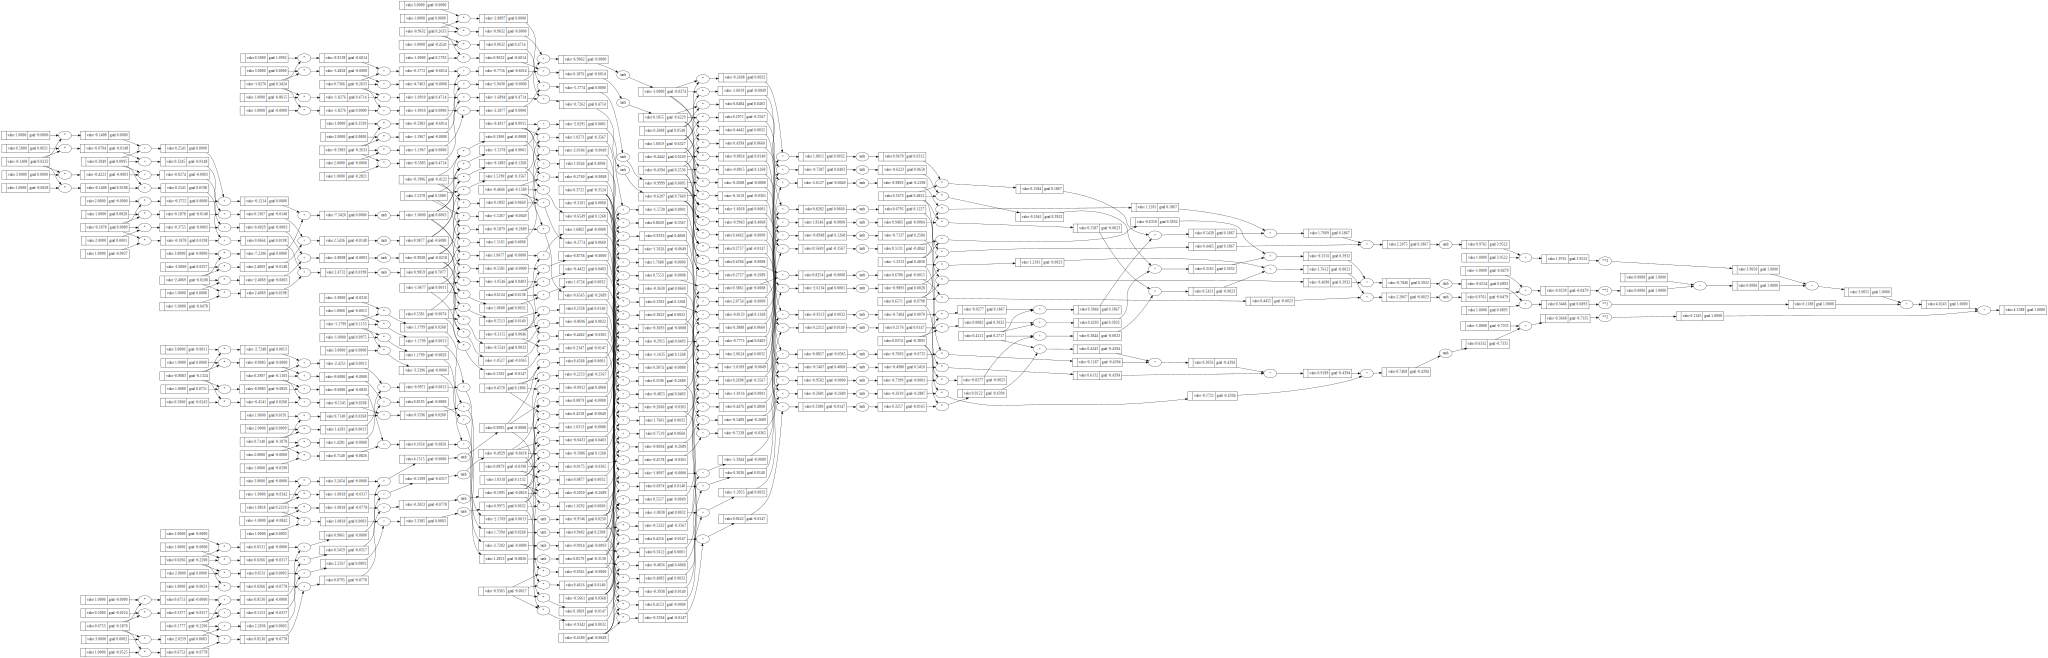

In [59]:
graficar(perdida)

In [60]:
RN.parametros()

[Valor=-0.14076685766617603,
 Valor=-0.18775463862846525,
 Valor=-2.4068655703246096,
 Valor=0.3948772894293564,
 Valor=0.675305981196607,
 Valor=0.02656171333125345,
 Valor=1.0817908172732715,
 Valor=0.17766152717382425,
 Valor=-0.9082630920843692,
 Valor=0.7140367527263409,
 Valor=-1.179873103479951,
 Valor=0.29965086120402085,
 Valor=-1.827611293728896,
 Valor=-0.5983442948615403,
 Valor=-0.9632185921530874,
 Valor=0.7365666714368985,
 Valor=0.5581210827689915,
 Valor=-0.9365419028696852,
 Valor=-0.4189159166652069,
 Valor=-0.44422043723097465,
 Valor=-0.31550488080193306,
 Valor=-1.067736021861725,
 Valor=0.08791882354330935,
 Valor=-0.310083388318183,
 Valor=0.2608413923237044,
 Valor=0.6124242540498416,
 Valor=1.537830901570082,
 Valor=0.45697728681064514,
 Valor=-0.5660787680474958,
 Valor=1.6018845348778326,
 Valor=-0.491680557079692,
 Valor=-0.19060912179938513,
 Valor=1.0318410144380104,
 Valor=0.37249317640320073,
 Valor=-0.4394023187736715,
 Valor=-0.4665939779060704,
 Valo

In [61]:
for p in RN.parametros():
  p.valor += -0.1 * p.grad # queremos disminuir el resultado final, por eso restamos

In [62]:
predicciones

[Valor=0.9760640284876828,
 Valor=0.9760988173157867,
 Valor=-0.6553534221135854,
 Valor=0.6332366822158839]

In [81]:
for k in range(20):

  # paso hacia delante
  preds = [RN(x) for x in entradas]
  perdida = sum([(pred - obj)**2 for pred, obj in zip(preds, objetivos)])

  # propagación hacia atrás, SGD
  for p in RN.parametros():
    p.grad = 0.0
  perdida.propagar()

  # actualizar
  for p in RN.parametros():
    p.valor += -0.07 * p.grad

  print(k, perdida.valor)

0 0.07865136658436922
1 0.07422913365830558
2 0.07025525069827339
3 0.06666454720835668
4 0.06340437535292762
5 0.06043156929543031
6 0.05771030217421505
7 0.05521053045612033
8 0.052906836783511005
9 0.05077755151040299
10 0.04880407421947763
11 0.046970341923085135
12 0.04526240690272317
13 0.04366809784597769
14 0.04217674517604481
15 0.04077895647376315
16 0.03946643142458864
17 0.03823180826167562
18 0.037068535530402034
19 0.035970764373594026


In [87]:
preds

[Valor=0.8915921612361354,
 Valor=-0.8772699525368586,
 Valor=-0.9496828880774285,
 Valor=0.9186118647123033]

In [83]:
objetivos

[1.0, -1.0, -1.0, 1.0]